In [7]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler

import tensorflow as tf

df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")
df = df.groupby(by=["periodo","product_id"]).agg({"tn":"sum"}).reset_index()
df = df[~df["periodo"].isin([201911, 201912])]
df_test = df[df["periodo"] == 201912].copy()
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df_pivot = df.pivot(index="product_id", columns="periodo", values="tn").fillna(0)

del df
gc.collect()


# --- FILTRAR PRODUCTOS CON AL MENOS 3 MESES DE ANTIGÜEDAD ---
# Opción 1: Al menos 3 meses con datos (no necesariamente consecutivos)
productos_con_3_meses = (df_pivot > 0).sum(axis=1) >= 3
df_pivot = df_pivot[productos_con_3_meses]
print(f"Shape de la matriz: {df_pivot.shape}")  # (800 productos x 36 meses)

Shape de la matriz: (1156, 34)


In [8]:
df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")# Verificar si el mes 20127 está presente
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df[df["product_id"]==20127]

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
2732958,2019-09-01,10217,20127,0,1,0.12322,0.12322
2732959,2019-09-01,10109,20127,0,1,0.61612,0.61612
2732960,2019-09-01,10027,20127,0,4,6.04913,6.04913
2732961,2019-09-01,10343,20127,0,1,0.04481,0.04481
2732962,2019-09-01,10208,20127,0,1,0.12322,0.12322
...,...,...,...,...,...,...,...
2941559,2019-12-01,10175,20127,0,1,0.36967,0.36967
2941560,2019-12-01,10236,20127,0,1,1.72512,1.72512
2941561,2019-12-01,10092,20127,0,1,0.56011,0.56011
2941562,2019-12-01,10473,20127,0,1,0.03361,0.03361


HIPERPARAMETROS

In [9]:
window_size = 12  # Ventana de  meses
scaler_name = "robust"  # "standard" o "robust"
epochs = 150  
early_stopping_patience = 15
l2_lambda = 0.001  # Ajusta este valor según sea necesario (típicamente 0.01, 0.001, etc.)
optimizer = "rmsprop"  # "adam", "sgd", "rmsprop", etc.
batch_size = 250

In [10]:

scalers = {}  # Guardamos los scalers para invertir luego
scaled_data = np.zeros_like(df_pivot.values)

for i, (producto, fila) in enumerate(df_pivot.iterrows()):
    scaler = StandardScaler() if scaler_name == "standard" else RobustScaler()
    scaled_data[i] = scaler.fit_transform(fila.values.reshape(-1, 1)).flatten()
    scalers[producto] = scaler  # Almacenar scaler para este producto

In [11]:
X, y, productos = [], [], []

for i_producto, producto in enumerate(df_pivot.index):
    serie = scaled_data[i_producto]
    for i in range(window_size, len(serie) - 2):  # Asegurar que t+2 exista
        X.append(serie[i-window_size:i].reshape(-1, 1))  # Shape: (12, 1)
        y.append(serie[i+2])  # t+2 (i+1 es el offset desde el fin de la ventana)
        productos.append(producto)  # Identificador del producto

X = np.array(X)  # Shape: (n_muestras, 12, 1)
y = np.array(y).reshape(-1, 1)  # Shape: (n_muestras, 1)

In [12]:
from sklearn.model_selection import train_test_split

productos_unicos = df_pivot.index.unique()
productos_train, productos_test = train_test_split(productos_unicos, test_size=0.2, random_state=42)

# Máscaras para filtrar
train_mask = [p in productos_train for p in productos]
test_mask = [p in productos_test for p in productos]

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
def get_reg(l2_lambda):
    return l2(l2_lambda) if l2_lambda > 0 else None

def custom_mape_loss(y_true, y_pred):
    """
    Función de pérdida personalizada basada en el error porcentual absoluto.
    - y_true: Valores reales (ground truth).
    - y_pred: Predicciones del modelo.
    """
    absolute_error = tf.abs(y_true - y_pred)
    sum_absolute_error = tf.reduce_sum(absolute_error)
    sum_true = tf.reduce_sum(y_true)
    return (sum_absolute_error / sum_true)  # Multiplicar por 100 para porcentaje


model = Sequential([
    LSTM(64, activation='tanh', 
         input_shape=(window_size, 1), 
         return_sequences=True,
         kernel_regularizer=get_reg(l2_lambda)),  # Regularización L2 en LSTM
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(1)  # Salida para t+2
])

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

callbacks = [
    EarlyStopping(patience=early_stopping_patience,
                  restore_best_weights=True,
                #   monitor='val_custom_mape_loss',
                #   min_delta=0.001,
                #   mode='min',
                  ),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/150
74/74 [==============================] - 15s 46ms/step - loss: 20.3776 - mae: 0.9988 - val_loss: 17.9530 - val_mae: 0.9831 - lr: 0.0010
Epoch 2/150
74/74 [==============================] - 1s 16ms/step - loss: 19.6288 - mae: 0.9880 - val_loss: 17.5298 - val_mae: 1.0016 - lr: 0.0010
Epoch 3/150
74/74 [==============================] - 1s 16ms/step - loss: 19.2647 - mae: 1.0059 - val_loss: 17.2310 - val_mae: 1.1250 - lr: 0.0010
Epoch 4/150
74/74 [==============================] - 1s 16ms/step - loss: 18.9964 - mae: 1.0176 - val_loss: 17.1546 - val_mae: 0.9508 - lr: 0.0010
Epoch 5/150
74/74 [==============================] - 1s 16ms/step - loss: 18.8296 - mae: 0.9873 - val_loss: 16.9258 - val_mae: 1.1383 - lr: 0.0010
Epoch 6/150
74/74 [==============================] - 1s 17ms/step - loss: 18.7300 - mae: 1.0102 - val_loss: 16.9498 - val_mae: 0.9903 - lr: 0.0010
Epoch 7/150
74/74 [==============================] - 1s 19ms/step - loss: 18.6264 - mae: 0.9936 - val_loss: 16.9099 -

In [15]:
def predecir_t2(product_id, ultimos_12_meses):
    """
    product_id: ID del producto (ej: 'P001').
    ultimos_12_meses: Array con las tn de los últimos 12 meses (en orden cronológico).
    """
    scaler = scalers[product_id]
    ultimos_12_scaled = scaler.transform(np.array(ultimos_12_meses).reshape(-1, 1))
    X_new = ultimos_12_scaled.reshape(1, window_size, 1)
    y_pred_scaled = model.predict(X_new)
    return (y_pred_scaled * scaler.scale_) + scaler.center_

# Ejemplo: Predecir para el primer producto en el test set
producto_ejemplo = productos_test[0]
ultimos_12_ejemplo = df_pivot.loc[producto_ejemplo].iloc[-window_size:].values
prediccion = predecir_t2(producto_ejemplo, ultimos_12_ejemplo)
print(f"Predicción t+2 para {producto_ejemplo}: {prediccion[0][0]:.2f} tn")

1/1 [==============================] - 1s 894ms/step
Predicción t+2 para 20996: 0.84 tn


In [16]:
productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")
productos_ok = productos_ok["product_id"].unique()

productos_ok = [p for p in productos_ok if p in df_pivot.index]
def predecir_todos(productos_a_predecir):
    predicciones = {}
    for producto in productos_a_predecir:
        ultimos_12 = df_pivot.loc[producto].iloc[-window_size:].values
        prediccion = predecir_t2(producto, ultimos_12)
        predicciones[producto] = prediccion[0][0]
    return predicciones
predicciones = predecir_todos(productos_ok)
predicciones_df = pd.DataFrame.from_dict(predicciones, orient='index', columns=['prediccion_t2'])
predicciones_df.index.name = 'product_id'
predicciones_df.reset_index(inplace=True)
predicciones_df

1/1 [==============================] - 0s 27ms/step


,product_id,prediccion_t2
0,20001,1272.876443
1,20002,1004.045602
2,20003,769.993699
3,20004,701.603339
4,20005,533.469662
...,...,...
766,21263,0.005603
767,21265,-0.046104
768,21266,-0.047302
769,21267,-0.103017


In [17]:
predicciones_df.columns = ["product_id", "y_pred"]
#predicciones_df.to_csv("../../results/LSTM_2.csv", index=False, sep=",")

In [18]:
df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")
df = df.groupby(by=["periodo","product_id"]).agg({"tn":"sum"}).reset_index()
df_test = df[df["periodo"] == 201912].copy()

In [19]:
df_final = df_test.merge(predicciones_df, on="product_id", how="left")
# df_final.to_csv("LSTM_2_test.csv", index=False, sep=",")

In [20]:
df_final

,periodo,product_id,tn,y_pred
0,201912,20001,1504.68856,1272.876443
1,201912,20002,1087.30855,1004.045602
2,201912,20003,892.50129,769.993699
3,201912,20004,637.90002,701.603339
4,201912,20005,593.24443,533.469662
...,...,...,...,...
922,201912,21265,0.05007,-0.046104
923,201912,21266,0.05121,-0.047302
924,201912,21267,0.01569,-0.103017
925,201912,21271,0.00298,NaN


In [21]:
numerador = (df_final["tn"]- df_final["y_pred"]).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error = (numerador / denominador)
porcentaje_error

0.32591058914890714

In [22]:
resultados = {
    "window_size": window_size,
    "scaler_name": scaler_name,
    "epochs": epochs,
    "early_stopping_patience": early_stopping_patience,
    "l2_lambda": l2_lambda,
    "optimizer": optimizer,
    "batch_size": batch_size,
    "porcentaje_error": porcentaje_error
}
with open("resultados.txt", "a") as f:
    f.write(",".join([str(v) for v in resultados.values()])  + "\n")

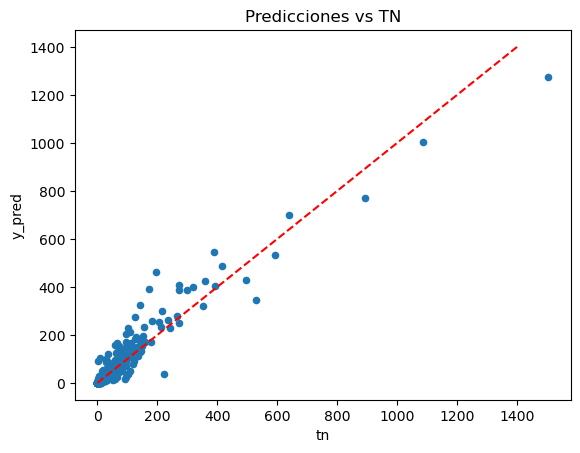

In [23]:
import matplotlib.pyplot as plt
df_final["pred_085"] = df_final["y_pred"] * 0.85
df_final.plot(kind="scatter", x="tn", y="y_pred", title="Predicciones vs TN")
plt.plot([0, 1400], [0, 1400], 'r--')
plt.show()

In [24]:
print(df_final["y_pred"].sum(),"|",df_final["tn"].sum())

28147.93925798368 | 26217.067280000003


In [25]:
1/(df_final["y_pred"].sum()/df_final["tn"].sum())

0.9314027232939968

In [26]:
df_final["y_pred"].sum()*0.865

24347.967458155883

In [27]:
sellin = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

C:\Users\carre\AppData\Local\Temp\ipykernel_14716\621086552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')


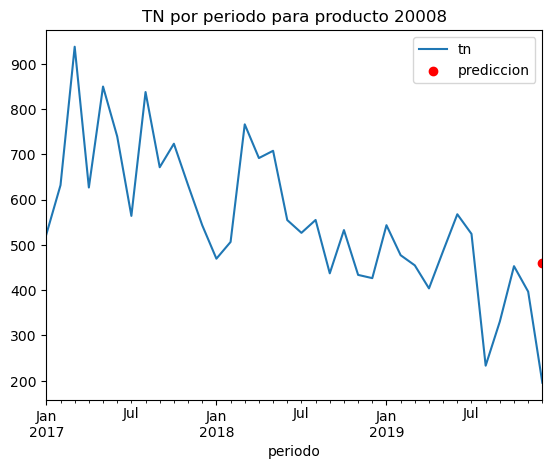

In [28]:


prod = 20008
prod_s = sellin[sellin["product_id"] == prod]
prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')
prod_s = prod_s.groupby("periodo").agg({"tn": "sum"}).reset_index()
#prod_s.plot(kind="line", x="periodo", y="tn", title="TN por periodo para producto 20002")

import matplotlib.pyplot as plt

ax = plt.gca()
prod_s.plot(kind="line", x="periodo", y="tn", title=f"TN por periodo para producto {prod}", ax=ax)
#plt.axhline(y=813.82, color='red', linestyle='--', label='predict')
prediccion = df_final[df_final["product_id"] == prod]["y_pred"].values[0]
plt.scatter(prod_s["periodo"].iloc[-1], prediccion, color='red', label='prediccion')
plt.legend()
plt.show()

In [29]:
df_final["error"] = (df_final["tn"] - df_final["y_pred"]).abs()
df_final["error_relativo"] = df_final["error"] / df_final["tn"]
df_final.sort_values(by="error", ascending=False, inplace=True)

In [30]:
df_final

,periodo,product_id,tn,y_pred,pred_085,error,error_relativo
7,201912,20008,195.36854,460.382518,391.325140,265.013978,1.356482
0,201912,20001,1504.68856,1272.876443,1081.944977,231.812117,0.154060
11,201912,20012,173.13004,391.497976,332.773280,218.367936,1.261294
31,201912,20032,527.79811,343.578985,292.042138,184.219125,0.349033
78,201912,20085,221.56404,38.412306,32.650460,183.151734,0.826631
...,...,...,...,...,...,...,...
912,201912,21247,0.14544,NaN,NaN,NaN,NaN
915,201912,21255,0.00328,NaN,NaN,NaN,NaN
917,201912,21257,0.01158,NaN,NaN,NaN,NaN
921,201912,21264,0.00890,NaN,NaN,NaN,NaN
